In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame


from numpy import dstack

import copy

import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

from keras.models import model_from_json


from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import random

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from matplotlib import pyplot


Using TensorFlow backend.


## Load model

In [2]:
# load json and create model
json_file = open('model-0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model-0.h5")
print("Loaded model from disk")

Loaded model from disk


## Load samples

In [3]:
def pad_with_zeros(orig_ndarray, desired_rows_count):
    (frames, features) = orig_ndarray.shape

    sample_df = pd.DataFrame(data=orig_ndarray,
                             index=np.arange(frames),
                             columns=np.arange(features))

    zeros_df = pd.DataFrame(0,
                            index=np.arange(desired_rows_count),
                            columns=np.arange(features),
                            dtype='float')

    for i in range(features):
        zeros_df[i] = sample_df[i].astype(float)
    
    
    padded_df = zeros_df.fillna(0)

    return padded_df.to_numpy()

def filter_active_keypoints(frame_df):
    #active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7] # trunk
    
    active_keypoints = [0, 1, 8, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
    
    filtered_df  = frame_df[frame_df.index.isin(active_keypoints)]
    #filtered_df = frame_df

    return filtered_df

def get_frame_data(filepath):
    frame_data = pd.read_csv(filepath)
    
    x_data = filter_active_keypoints(frame_data.iloc[:, 0])
    y_data = filter_active_keypoints(frame_data.iloc[:, 1])
    
    #print(f"x_data shape: {x_data.shape}")
    #print(f"y_data shape: {y_data.shape}")
        
    h_stacked = np.hstack((x_data, y_data))
    #h_stacked = np.hstack((y_data))
    
    return h_stacked

def get_frame_file_path(frame_file_path_template, frame_idx):
    frame_file_path = frame_file_path_template.replace("[frame_idx]", str(frame_idx))
    return frame_file_path

def get_frames_count(root_path, sample_dir_name):
    return len([Path(f).abspath() for f in glob(f"{root_path}/{sample_dir_name}" + '/*')])

def get_frames(root_path, sample_dir_name):
    frames = []
    for frame_idx in range(0, get_frames_count(root_path, sample_dir_name)):
        frame_file_path_template = f"{root_path}/{sample_dir_name}/{sample_dir_name}.mov-[frame_idx]-0.csv"
        frame_file_path = get_frame_file_path(frame_file_path_template, frame_idx)
        frame_data = get_frame_data(frame_file_path)
        
        frames.append(frame_data)
        
    return np.dstack(frames)

def get_samples_list(sample_dir_names, root_path):
    samples = []
    sample_names = []
    for sample_dir_name in sample_dir_names:
        frames = get_frames(root_path, sample_dir_name)
        squeezed = np.squeeze(frames)
        axes_swapped = np.swapaxes(squeezed, 0, 1)
        samples.append(axes_swapped)
        
        sample_names.append(sample_dir_name)
        
    return samples, sample_names

root_path = "/Users/allarviinamae/EduWorkspace/openpose-jupyter-data-exploration/centered-keypoints"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

samples, sample_names = get_samples_list(sample_dir_names, root_path)

def get_padded_samples(samples):
    padded_samples_list = []

    for idx, sample_ndarray in enumerate(samples):
        desired_rows_count = 110

        padded_ndarray = pad_with_zeros(sample_ndarray, desired_rows_count)

        padded_samples_list = padded_samples_list + [padded_ndarray]
        
    return padded_samples_list

padded_samples_list = get_padded_samples(samples)

padded_samples_beefy_list = padded_samples_list

print(f"padded samples len: {len(padded_samples_beefy_list)}")
padded_samples_beefy_ndarray = np.asarray(padded_samples_beefy_list)

padded samples len: 113


## Load labels

In [4]:
def get_label(sample_dir_name):
    return 0 if sample_dir_name[0] == 'b' else 1

def get_y_labels(sample_dir_names):
    return [get_label(l) for l in sample_dir_names]

y_labels = get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

y_labels_stacked = np.dstack(y_labels)
print(f"y_labels_stacked shape: {y_labels_stacked.shape}")

y_labels_categorical = to_categorical(y_labels_stacked) 
print(f"y_labels_categorical shape: {y_labels_categorical.shape}")

y_labels_squeezed = np.squeeze(y_labels_categorical)
print(f"y_labels_squeezed shape {y_labels_squeezed.shape}")

(y_rows, y_cols) = y_labels_squeezed.shape
y_labels_list = [[y_labels_squeezed[i, 0], y_labels_squeezed[i, 1]] for i in range(y_rows)]

y_labels_beefy_ndarray = np.asarray(y_labels_list)

y_labels_stacked shape: (1, 1, 113)
y_labels_categorical shape: (1, 1, 113, 2)
y_labels_squeezed shape (113, 2)


In [5]:
padded_samples_beefy_ndarray.shape

(113, 110, 30)

## Predict

In [6]:
ynew = loaded_model.predict_classes(padded_samples_beefy_ndarray)
# show the inputs and predicted outputs
for i in range(len(padded_samples_beefy_ndarray)):
    pred_y = ynew[i]
    actual_y = y_labels[i]
    
    same = False
    if pred_y == actual_y:
        same = True
    
    print("Name=%s, X=%s, Predicted=%s, Actual=%s, same=%s" % (sample_names[i], i, pred_y, actual_y, same))

Name=backflip-40-margus, X=0, Predicted=1, Actual=0, same=False
Name=flack-31-rasmus, X=1, Predicted=1, Actual=1, same=True
Name=flack-19-rasmus, X=2, Predicted=1, Actual=1, same=True
Name=flack-59-martin, X=3, Predicted=1, Actual=1, same=True
Name=backflip-66-allar, X=4, Predicted=0, Actual=0, same=True
Name=flack-55-martin, X=5, Predicted=1, Actual=1, same=True
Name=flack-68-rasmus, X=6, Predicted=1, Actual=1, same=True
Name=backflip-23-tiit, X=7, Predicted=0, Actual=0, same=True
Name=flack-7-hendrik, X=8, Predicted=1, Actual=1, same=True
Name=flack-4-martin, X=9, Predicted=1, Actual=1, same=True
Name=flack-15-rasmus, X=10, Predicted=1, Actual=1, same=True
Name=flack-36-hendrik, X=11, Predicted=1, Actual=1, same=True
Name=backflip-64-allar, X=12, Predicted=0, Actual=0, same=True
Name=backflip-6-rasmus, X=13, Predicted=0, Actual=0, same=True
Name=flack-82-martin, X=14, Predicted=1, Actual=1, same=True
Name=flack-35-margus, X=15, Predicted=1, Actual=1, same=True
Name=backflip-38-mario,

## Confusion Matrix

    0   1
0  48   3
1   0  62


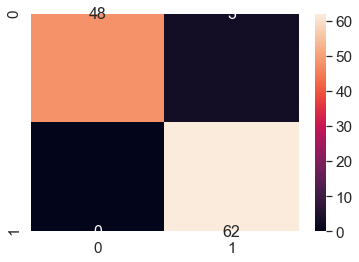

In [28]:
from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


matrix = confusion_matrix(y_labels, ynew)

#df_cm = pd.pivot_table(data=sns.load_dataset("flights"),
#                       index='month',
#                       values='passengers',
#                       columns='year')

df_cm = pd.DataFrame(matrix,
                     index = [i for i in "01"],
                     columns = [i for i in "01"])

print(df_cm.head())

plt.figure()
plt.xlabel('Actual', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 15) # y-axis label with fontsize 15

sn.set(font_scale=1.4) # for label size
sn.heatmap(
    df_cm, 
    annot=True,
    annot_kws={"size": 16}
    )